In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']  # Specify the sans-serif font to use
import os
import scipy as sp
from scipy.stats import stats
import random
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split, KFold
from scipy.optimize import dual_annealing
import pickle as pkl

In [3]:
# Load the data
DATA_PATH = '../data/'
all_data = pkl.load(open(os.path.join(DATA_PATH, 'all_data.pkl'), 'rb'))
for patient_id in all_data.keys():
    all_data[patient_id]['data'] = all_data[patient_id]['data'].drop([index for index in all_data[patient_id]['data'].index if 'REPLAN' in index or 'RT' in index or 'PT' in index])
# print(np.array(all_data['001']['data']['volume difference to pCT [cm^3]'].values))

patients = [{'patient_id': int(patient_id.lstrip('0'))-1,
             'volume': all_data[patient_id]['data']['volume difference to pCT [%]'].values,
             'label': all_data[patient_id]['label'][0]
            }
             for patient_id in all_data.keys()]

df = pd.DataFrame(patients)
df['replanned'] = df['label'].apply(lambda x: 1 if x > 0 else 0)
df

,patient_id,volume,label,replanned
0,0,"[-2.310914988877491, -1.2161034168501834, -1.9...",8,1
1,1,"[0.1234078509981191, -0.5164712452615666, -0.1...",12,1
2,2,"[6.030770401365178, 4.53825133892202, 4.623778...",17,1
3,3,"[3.772012610831661, 2.3167415939782696, 0.0704...",22,1
4,4,"[1.9940811271194985, 1.2659015125248567, 1.751...",22,1
5,5,"[0.1728967801988862, -1.2641353922988956, 1.29...",19,1
6,6,"[-1.9912083007982888, -0.9957131599326806, 0.4...",10,1
7,7,"[0.6351318288797102, 0.0667727691085405, -1.03...",21,1
8,8,"[3.8753307188695874, -0.448672649947458, -4.33...",17,1
9,9,"[1.4257115051900584, 1.6179953687483155, -0.45...",26,1


In [37]:
# Create a DataFrame from the list of dictionaries and group based on label
# print(patients)
# Group by replanned and calculate the mean and standard deviation of volume

df_replanned     = df[df['replanned'] == 1].copy()   # patients who were replanned
df_not_replanned = df[df['replanned'] == 0].copy()   # patients who were not replanned

# Dictionary and the volume difference to pCT as value for all patients.
# E.g. fraction 1: [patient 1, patient 2, ...]
replanned_fraction_dict = {f'fraction {i}':[] for i in range(1, 36)}
ordinary_fraction_dict = {f'fraction {i}':[] for i in range(1, 36)}


replanned_day_counter = [0] * 36 # 36 with some buffer as no patients has more than 36 fractions
replanned_value_list = [0] * 36
ordinary_day_counter = [0] * 36
ordinary_value_list = [0] * 36

for k, patient in enumerate(df_not_replanned['patient_id']):
    print(f'patient {patient} ordinary')
    for i in range(df_not_replanned.iloc[k]['volume'].shape[0]): # Length of the fractions for the patient
        ordinary_value_list[i] += df_not_replanned.iloc[k]['volume'][i] # Add the ith fraction to the list at position i
        ordinary_day_counter[i] += 1 # Increase the counter of the ith day by one
        # Append the value of the ith fraction for the patient to the dictionary at the right position
        ordinary_fraction_dict[f'fraction {i+1}'].append(df_not_replanned.iloc[k]['volume'][i])

for k, patient in enumerate(df_replanned['patient_id']):
    print(f'patient {patient} replanned')
    for i in range(df_replanned.iloc[k]['volume'].shape[0]): # Length of the fractions for the patient
        replanned_value_list[i] += df_replanned.iloc[k]['volume'][i] # Add the ith fraction to the list at position i
        replanned_day_counter[i] += 1 # Increase the counter of the ith day by one
        # Append the value of the ith fraction for the patient to the dictionary at the right position
        replanned_fraction_dict[f'fraction {i+1}'].append(df_replanned.iloc[k]['volume'][i])              
        


print(f'on fraction 7, replanned mean is {np.mean(replanned_fraction_dict["fraction 7"])} \\pm {np.std(replanned_fraction_dict["fraction 7"])} and ordinary mean is {np.mean(ordinary_fraction_dict["fraction 7"])} \\pm {np.std(ordinary_fraction_dict["fraction 7"])}')
print(f'on fraction 14, replanned mean is {np.mean(replanned_fraction_dict["fraction 14"])} \\pm {np.std(replanned_fraction_dict["fraction 14"])} and ordinary mean is {np.mean(ordinary_fraction_dict["fraction 14"])} \\pm {np.std(ordinary_fraction_dict["fraction 14"])}')
print(f'on fraction 21, replanned mean is {np.mean(replanned_fraction_dict["fraction 21"])} \\pm {np.std(replanned_fraction_dict["fraction 21"])} and ordinary mean is {np.mean(ordinary_fraction_dict["fraction 21"])} \\pm {np.std(ordinary_fraction_dict["fraction 21"])}')

#same for median
print(f'on fraction 7, replanned median is {np.median(replanned_fraction_dict["fraction 7"])} and ordinary median is {np.median(ordinary_fraction_dict["fraction 7"])}')
print(f'on fraction 14, replanned median is {np.median(replanned_fraction_dict["fraction 14"])} and ordinary median is {np.median(ordinary_fraction_dict["fraction 14"])}')
print(f'on fraction 21, replanned median is {np.median(replanned_fraction_dict["fraction 21"])} and ordinary median is {np.median(ordinary_fraction_dict["fraction 21"])}')

for frac in [f'fraction {i+1}' for i in range(33)]:
    # # Check for equal variances using Levene's test
    # levene_stat, levene_p = sp.stats.levene(replanned_fraction_dict[frac], ordinary_fraction_dict[frac])

    # # Perform t-test
    # if levene_p > 0.05:
    #     t_stat, t_p = sp.stats.ttest_ind(replanned_fraction_dict[frac], ordinary_fraction_dict[frac], equal_var=True)
    # else:
    #     # Unequal veriances (Welche's t-test)
    #     print('Warning: Unequal variances, performing Welchls t-test')
    #     t_stat, t_p = sp.stats.ttest_ind(replanned_fraction_dict[frac], ordinary_fraction_dict[frac], equal_var=False)
    t_stat, t_p = sp.stats.ttest_ind(replanned_fraction_dict[frac], ordinary_fraction_dict[frac], equal_var=False)
    if t_p < 0.05:
        print(f'{frac}:T-statistic: {t_stat}, p-value: {t_p}')
    # else:
    #     print(f'{frac}:T-statistic: {t_stat}, p-value: {t_p}')

ordinary_mean_list = []
ordinary_std_list = []
replanned_mean_list = []
replanned_std_list = []
for i in range(len(replanned_value_list)):
    assert len(replanned_fraction_dict) == len(ordinary_fraction_dict), 'Error: Length of replanned and ordinary fraction dictionaries do not match'
    try:
        # print(f'mean of day {i} is {replanned_value_list[i]/replanned_day_counter[i]} for replanned patients')
        # print(f'mean of day {i} is {ordinary_value_list[i]/ordinary_day_counter[i]} for ordinary patients')
        ordinary_mean_list.append(ordinary_value_list[i]/ordinary_day_counter[i])
        replanned_mean_list.append(replanned_value_list[i]/replanned_day_counter[i])
        ordinary_std_list.append(np.std(ordinary_fraction_dict[f'fraction {i+1}']))
        replanned_std_list.append(np.std(replanned_fraction_dict[f'fraction {i+1}']))
    except:
        print(f'Error: Could not calculate mean for day {i+1}')

# print('ind t-test on means')
# for n in range(1, len(replanned_mean_list)+1):
#     # Check for equal variances using Levene's test
#     # print(replanned_mean_list[:n])
#     levene_stat, levene_p = sp.stats.levene(replanned_mean_list[:n], ordinary_mean_list[:n])

#     # Perform t-test
#     if levene_p > 0.05:
#         t_stat, t_p = sp.stats.ttest_ind(replanned_mean_list[:n], ordinary_mean_list[:n], equal_var=True)
#     else:
#         # Unequal veriances (Welche's t-test)
#         # print('Warning: Unequal variances, performing Welchls t-test')
#         t_stat, t_p = sp.stats.ttest_ind(replanned_mean_list[:n], ordinary_mean_list[:n], equal_var=False)

#     if t_p < 0.05:
#         print(f'fraction {n}:T-statistic: {t_stat}, p-value: {t_p}')
#     # print(f':T-statistic: {t_stat}, p-value: {t_p}')

patient 10 ordinary
patient 12 ordinary
patient 14 ordinary
patient 16 ordinary
patient 17 ordinary
patient 18 ordinary
patient 20 ordinary
patient 0 replanned
patient 1 replanned
patient 2 replanned
patient 3 replanned
patient 4 replanned
patient 5 replanned
patient 6 replanned
patient 7 replanned
patient 8 replanned
patient 9 replanned
patient 11 replanned
patient 13 replanned
patient 15 replanned
patient 19 replanned
on fraction 7, replanned mean is -0.7651256850236933 \pm 1.3835395461436055 and ordinary mean is 0.98291494947944 \pm 1.3060614668419566
on fraction 14, replanned mean is -2.4812305817992524 \pm 2.4382067143010127 and ordinary mean is 0.6961689635473657 \pm 1.7148826234035441
on fraction 21, replanned mean is -4.243210973456232 \pm 2.0988960760663926 and ordinary mean is 0.30019556022899085 \pm 1.417433514520098
on fraction 7, replanned median is -0.5455368082190977 and ordinary median is 1.005158374654055
on fraction 14, replanned median is -1.6812945363341543 and ordi

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

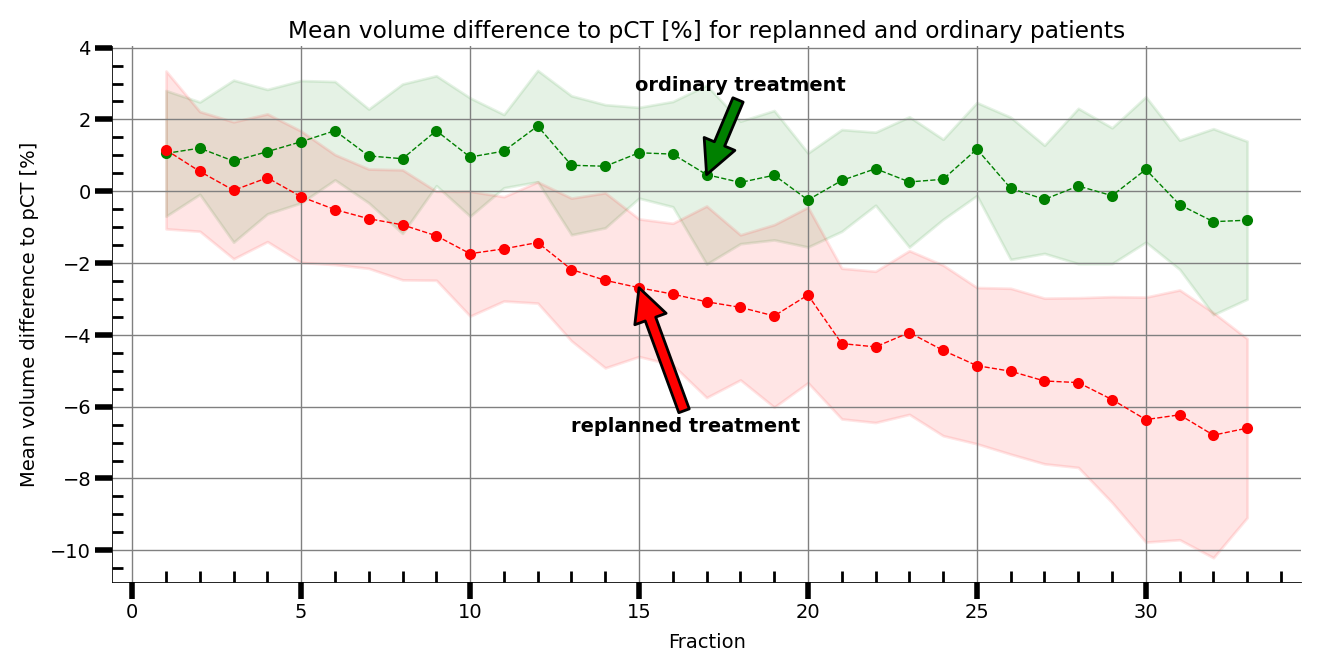

findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tahoma
findfont: Generic family 'sans-serif' not foun

In [33]:
figwidth = 469 / 72.27
with plt.style.context('../plot_style.txt'):
    fig, ax = plt.subplots(figsize=(figwidth, figwidth/2), layout='constrained')
    ax.set_title('Mean volume difference to pCT [%] for replanned and ordinary patients',)
    ax.set_xlabel('Fraction', )
    ax.set_ylabel('Mean volume difference to pCT [%]', )
    # ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))  
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  
    ax.yaxis.set_major_locator(plt.MultipleLocator(2))  
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    ax.tick_params(axis='x', which='major', direction='out', length=6, width=2)
    ax.tick_params(axis='x', which='minor', direction='in', length=4, width=1)
    ax.tick_params(axis='y', which='major', direction='out', length=6, width=2)
    ax.tick_params(axis='y', which='minor', direction='in', length=4, width=1)
    # y_min = -10
    # y_max = 3
    # plt.ylim(y_min, y_max)

    ax.plot(np.arange(1, len(ordinary_mean_list)+1), ordinary_mean_list, 'g.--', label='mean ordinary treatment')
    ax.plot(np.arange(1, len(replanned_mean_list)+1), replanned_mean_list, 'r.--', label='mean replanned treatment')
    # Fill the standard deviation
    ax.fill_between(np.arange(1, len(ordinary_mean_list)+1), np.array(ordinary_mean_list) - np.array(ordinary_std_list), np.array(ordinary_mean_list) + np.array(ordinary_std_list), color='green', alpha=0.1)
    ax.fill_between(np.arange(1, len(replanned_mean_list)+1), np.array(replanned_mean_list) - np.array(replanned_std_list), np.array(replanned_mean_list) + np.array(replanned_std_list), color='red', alpha=0.1)

    # Annotations with arrows
    x_ord = 17
    y_ord = ordinary_mean_list[x_ord-1]
    x_replanned = 15
    y_replanned = replanned_mean_list[x_replanned-1]
    ax.annotate('ordinary treatment', xy=(x_ord, y_ord), xytext=(x_ord+1, y_ord + 2.5),
                arrowprops=dict(facecolor='green',), ha='center', va='center', fontweight='bold', )
    ax.annotate('replanned treatment', xy=(x_replanned, y_replanned), xytext=(x_replanned -2, y_replanned - 4),
                arrowprops=dict(facecolor='red', ), fontweight='bold',  )



    ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # plt.legend()

    plt.show()
    # Save the figure

    fig.savefig('../figures/mean_volume_difference_replanned_vs_ordinary.pdf', bbox_inches='tight')